    Author: Anowar J. Shajib (ajshajib@astro.ucla.edu)
    Updated: April 17, 2019.

# HST data reduction for WFC3 IR

## Setup

In [1]:
import glob
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations
from astropy.visualization import LogStretch
from astropy.visualization import ImageNormalize
from astropy.visualization import LinearStretch
from astropy import wcs
from drizzlepac import astrodrizzle
from drizzlepac import tweakreg

%matplotlib inline



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


#### Specify raw data and output directories.

In [2]:
# Directory where data is stored
Main_dir = '/Volumes/T7/AGEL_data/16773/'

In [3]:
object_name = 'DESJ0537-4647'
band = 'F140W'
camera = 'WFC3'

raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/'.format(object_name,band,camera))
output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))

In [4]:
# create temp working directory in output_dir
temp_dir = output_data_dir + '/temp'

if os.path.isdir(temp_dir):
    shutil.rmtree(temp_dir)
    
os.mkdir(temp_dir)

# move raw data files to temporary directory to work on
for file in glob.glob(os.path.join(raw_data_dir, "*.fits")):
        shutil.copy2(file, temp_dir)

## See dithering

Plate scale: 0.1283


Text(0.5, 1.0, 'Dithering in pixel phase')

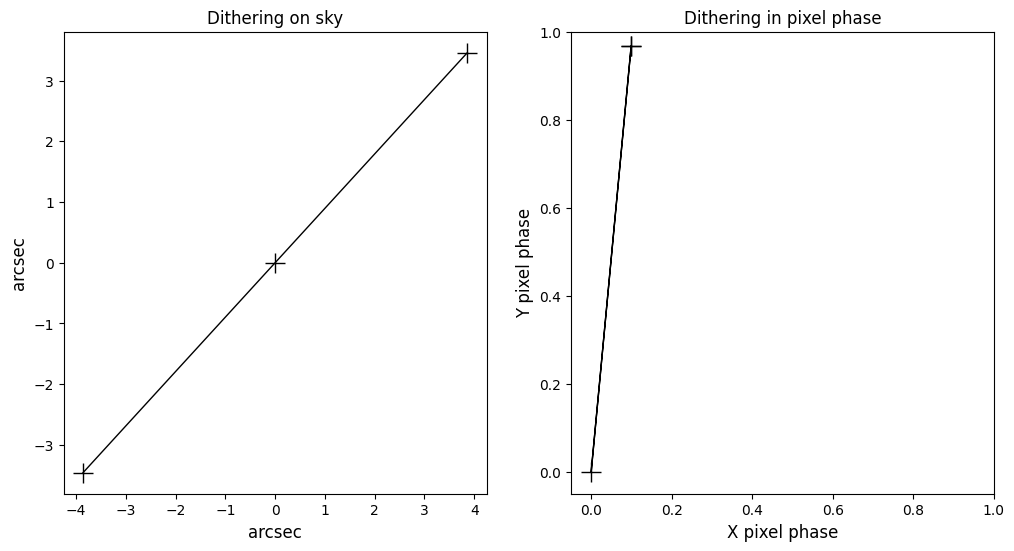

In [5]:
flt_files = glob.glob(temp_dir+'/*flt.fits')

plate_scale = fits.getval(flt_files[0], 'idcscale', ext=1)
print('Plate scale: {:>6.4f}'.format(plate_scale))
postarg1 = np.empty(len(flt_files), dtype=np.float)
postarg2 = np.empty(len(flt_files), dtype=np.float)
x_phase = np.empty(len(flt_files), dtype=np.float)
y_phase = np.empty(len(flt_files), dtype=np.float)

for i, im in enumerate(flt_files):
    with fits.open(im) as hdu:
        postarg1[i] = hdu[0].header['postarg1']
        postarg2[i] = hdu[0].header['postarg2']
        x_phase[i] = abs(np.modf(postarg1[i] / plate_scale)[0])
        y_phase[i] = abs(np.modf(postarg2[i] / plate_scale)[0])
        
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(postarg1, postarg2, 'k+-', ms=15, lw=1)
ax[0].set_xlabel('arcsec', fontsize='large')
ax[0].set_ylabel('arcsec', fontsize='large')
ax[0].set_title('Dithering on sky')

ax[1].plot(x_phase, y_phase, 'k+-', ms=15, lw=1)
ax[1].set_xlim(-0.05, 1)
ax[1].set_ylim(-0.05, 1)
ax[1].set_xlabel('X pixel phase', fontsize='large')
ax[1].set_ylabel('Y pixel phase', fontsize='large')
ax[1].set_title('Dithering in pixel phase')

This is 4-point IR-blob dithering. See [here](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2010-09.pdf) for details.

## Check alignment

To generate source lists for matching, the TweakReg parameter `conv_width` should be set to approximately twice the FWHM of the PSF, ~2.5 pixels for IR observations. TweakReg will automatically compute the standard deviation of the sky background (`skysigma`), so the number of sources in each catalog may be controlled simply by changing the ‘threshold’ parameter.

In this example, TweakReg is run in ‘non-interactive’ mode (`interactive='False'`) so that the astrometric fit residuals and vectors diagrams will be saved as png files in the local directory for inspection. Once the parameters have been fine-tuned and the fit looks adequate, you may run TweakReg a second time (see below) to update the image header WCS keywords by setting the parameter `updatehdr` to `True`.

Setting up logfile :  tweakreg.log
TweakReg Version 3.5.0 started at: 11:17:56.542 (03/01/2023) 

Version Information
--------------------
Python Version 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:54) [Clang 13.0.1 ]
numpy Version -> 1.23.3 
astropy Version -> 5.1 
stwcs Version -> 1.7.2 

Finding shifts for: 
    /Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1ygq_flt.fits
    /Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1yiq_flt.fits
    /Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1ykq_flt.fits

===  Source finding for image '/Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1ygq_flt.fits':
  #  Source finding for '/Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1ygq_flt.fits', EXT=('SCI', 1) started at: 11:17:56.668 (03/01/2023)
     Found 30 objects.
===  FINAL number of objects in image '/Volumes/T7/AGEL_data/16773/DESJ

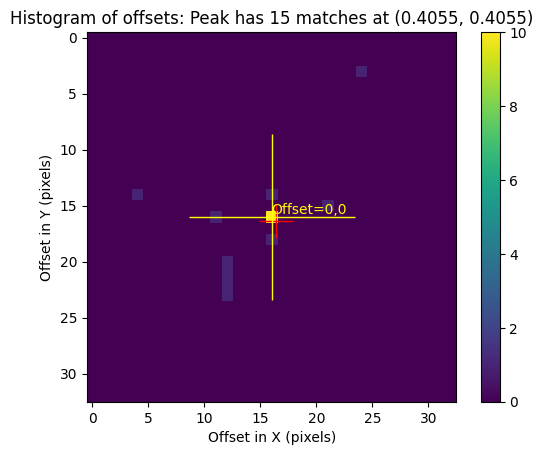

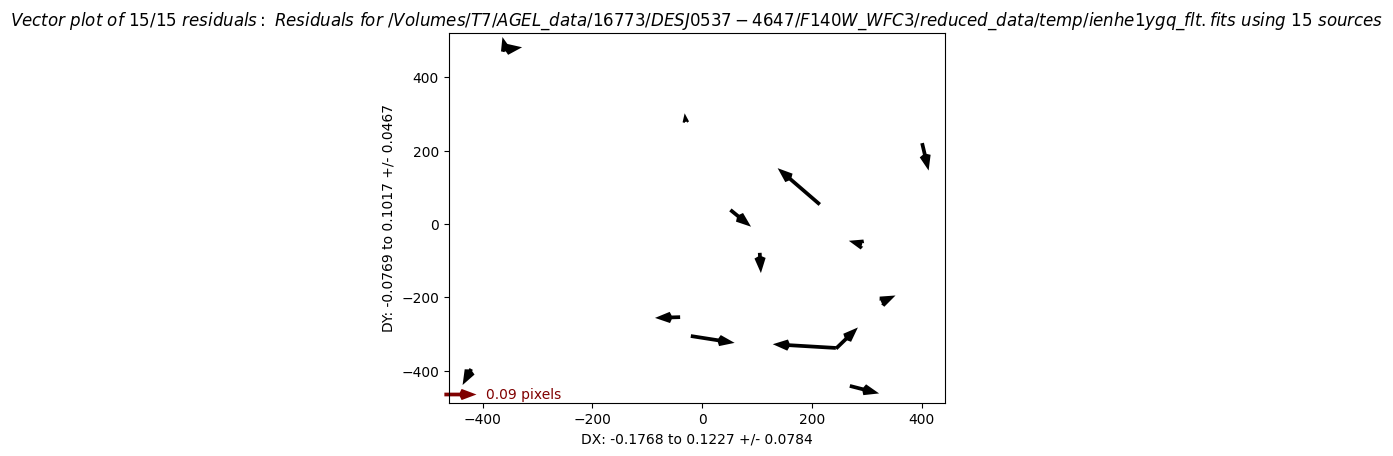

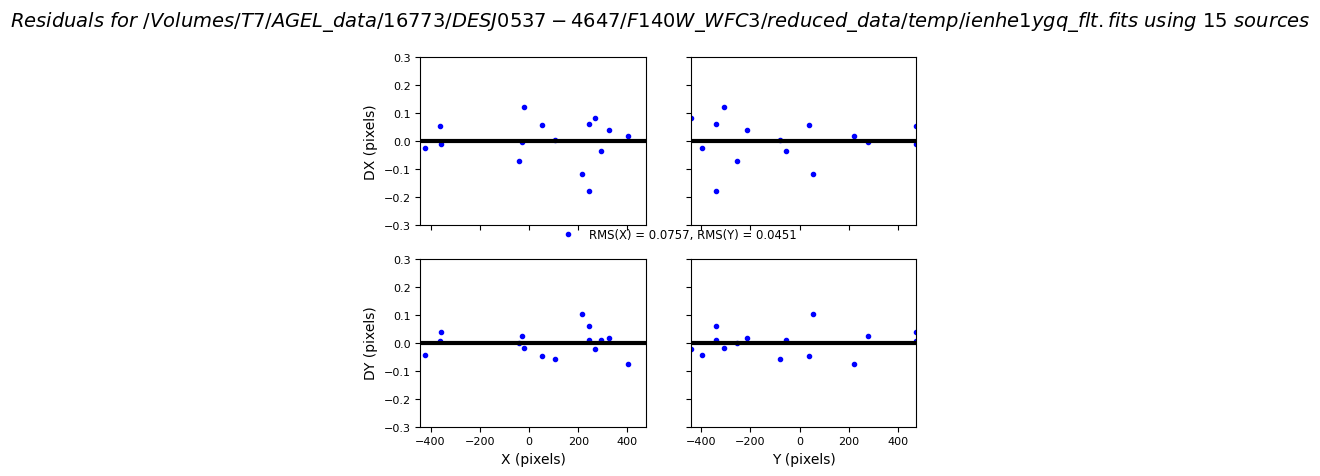

In [6]:
tweakreg.TweakReg(temp_dir+'/*flt.fits',
                  imagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  expand_refcat=True,
                  enforce_user_order=False,
                  shiftfile=True,
                  outshifts=temp_dir+'/shift140_flt.txt',
                  searchrad=2.0,
                  ylimit=0.3,
                  updatehdr=False,
                  reusename=True,
                  wcsname='IR_FLT',
                  interactive=False)

The $\Delta X$ and $\Delta Y$ in above figure should be $\lesssim0.1$ pixels. Otherwise, `AstroDrizzle` can't correctly detect cosmic rays.

Look the actual RMS values of $\Delta X$ and $\Delta Y$ in the table below.

In [7]:
shift_table = Table.read(temp_dir+'/shift140_flt.txt',
                         format='ascii.no_header', 
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str89,float64,float64,float64,float64,float64,float64
/Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1ygq_flt.fits,0.00,-0.04,359.995,1.00004,0.08,0.05
/Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1yiq_flt.fits,-0.01,-0.02,360.000,0.99997,0.06,0.05
/Volumes/T7/AGEL_data/16773/DESJ0537-4647/F140W_WFC3/reduced_data/temp/ienhe1ykq_flt.fits,0.00,0.00,0.000,1.00000,0.00,0.00


The pointing is accurate to ~0.07 IR pixel (~9 mas).

## Drizzle

Up-the-ramp sampling with calwf3 already removes cosmic rays in IR. But, there are still some odd pixels that stand out. So, we don't skip steps 3, 4, 5, and 6. Warm pixels are flagged with DQ=64, and we include them back as good pixels.

In [8]:
output = output_data_dir + '/' + object_name + '-0008_' + band + '_IR_ipynb'

astrodrizzle.AstroDrizzle(temp_dir+'/*flt.fits',
                          
                          # other parameters
                          output=output,
                          build=False, # if False, outputs sci, wht, and ctx into separate files
                          #resetbits=0, # default 4096
                          
                          # state of input files
                          preserve=False, # default True
                          clean=True, # default False
                          
                          # step 1: static mask
                          static=True,
                          static_sig=4., #default 4.
                          
                          # step 2: sky subtraction
                          skysub=False,
                          
                          # step 3: drizzle separate images
                          driz_separate=True,
                          driz_sep_kernel='turbo', # default 'turbo'
                          driz_sep_pixfrac=1., # default 1.
                          driz_sep_bits=0, # default 0
                          
                          # step 3a: custom WCS for separate outputs
                          driz_sep_scale=None, # default None
                          
                          # step 4: create median image
                          median=True, # default True
                          
                          # step 5: blot back the median image
                          blot=True, # default True
                          
                          # step 6: remove cosmic rays with deriv, driz_cr
                          driz_cr=True, # default True
                          driz_cr_corr=False, # default False
                          driz_cr_scale='2.2 0.7', # default '1.2 0.7'
                          #current value doesn't falsely detect
                          # the central pixels of the quasar images as CR. 
                          #driz_cr_snr='2. 1.5',
                          
                          # step 7: drizzle final combined image
                          driz_combine=True,
                          final_wht_type='EXP',
                          final_kernel='gaussian',
                          final_wt_scl='exptime',
                          final_pixfrac=0.7,
                          final_bits=64, # default 0, including warm pixels (DQ=64) back
                          
                          # step 7a: custom wcs for final output
                          final_wcs=True, # default False
                          final_rot=0,
                          final_scale=0.08,
                          
                          # instrument parameters
                          
                          # advanced parameters
)

Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.0 started at: 11:18:01.008 (03/01/2023)

==== Processing Step  Initialization  started at  11:18:01.016 (03/01/2023)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 84.35119453579705  -46.78625746687993  
CRPIX : 1156.7095022419494  1195.8343288721937  
CD1_1 CD1_2  : -2.222222222222222e-05  2.2262972651199973e-21  
CD2_1 CD2_2  : 8.88724331950497e-22  2.222222222222222e-05  
NAXIS : 2312  2393
********************************************************************************
*
*  Estimated memory usage:  up to 213 Mb.
*  Output image size:       2312 X 2393 pixels. 
*  Output image file:       ~ 63 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step Initialization finished at 11:18:01.903 (03/01/2023)
==== Processing Step  Static Mask  started at  11:18:01.906 (03/01/20

## Check drizzled image

(794.9999999995148, 894.9999999999527)

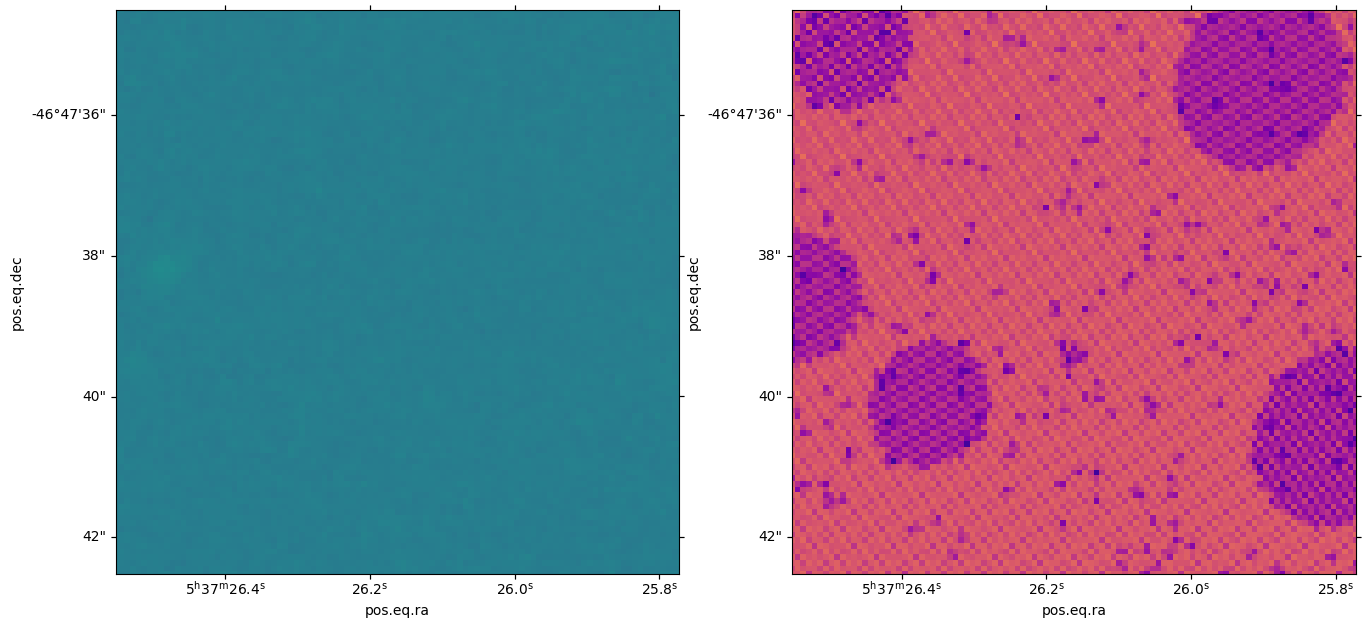

In [9]:
%matplotlib inline

sci_file = output + '_drz_sci.fits'
wht_file = output + '_drz_wht.fits'

with fits.open(sci_file) as hdu:
    im_wcs = wcs.WCS(hdu[0].header)
    sci = hdu[0].data

with fits.open(wht_file) as hdu:
    wht = hdu[0].data
    
radec_lims = wcs.utils.pixel_to_skycoord([865, 965], [795, 895], im_wcs)
        
norm = ImageNormalize(sci, vmin=-0.2, vmax=25, stretch=LogStretch())
fig, ax = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': im_wcs})
ax[0].imshow(sci, norm=norm, cmap='viridis', origin='lower')
ax[1].imshow(wht, cmap='plasma', origin='lower')

ax[0].set_xlim(radec_lims.to_pixel(im_wcs)[0])
ax[0].set_ylim(radec_lims.to_pixel(im_wcs)[1])

ax[1].set_xlim(radec_lims.to_pixel(im_wcs)[0])
ax[1].set_ylim(radec_lims.to_pixel(im_wcs)[1])

## Check bad pixels and cosmic ray flagging

/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykernel_27480/139190843.py:12: RuntimeWarning: divide by zero encountered in log10
  ax[row, col].matshow(np.log10(data), origin='upper')
/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykernel_27480/139190843.py:12: RuntimeWarning: invalid value encountered in log10
  ax[row, col].matshow(np.log10(data), origin='upper')
/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykernel_27480/139190843.py:12: RuntimeWarning: divide by zero encountered in log10
  ax[row, col].matshow(np.log10(data), origin='upper')
/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykernel_27480/139190843.py:12: RuntimeWarning: invalid value encountered in log10
  ax[row, col].matshow(np.log10(data), origin='upper')
/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykernel_27480/139190843.py:12: RuntimeWarning: divide by zero encountered in log10
  ax[row, col].matshow(np.log10(data), origin='upper')
/var/folders/45/123d1cvs0yjbj8_h1w1h0s580000gn/T/ipykerne

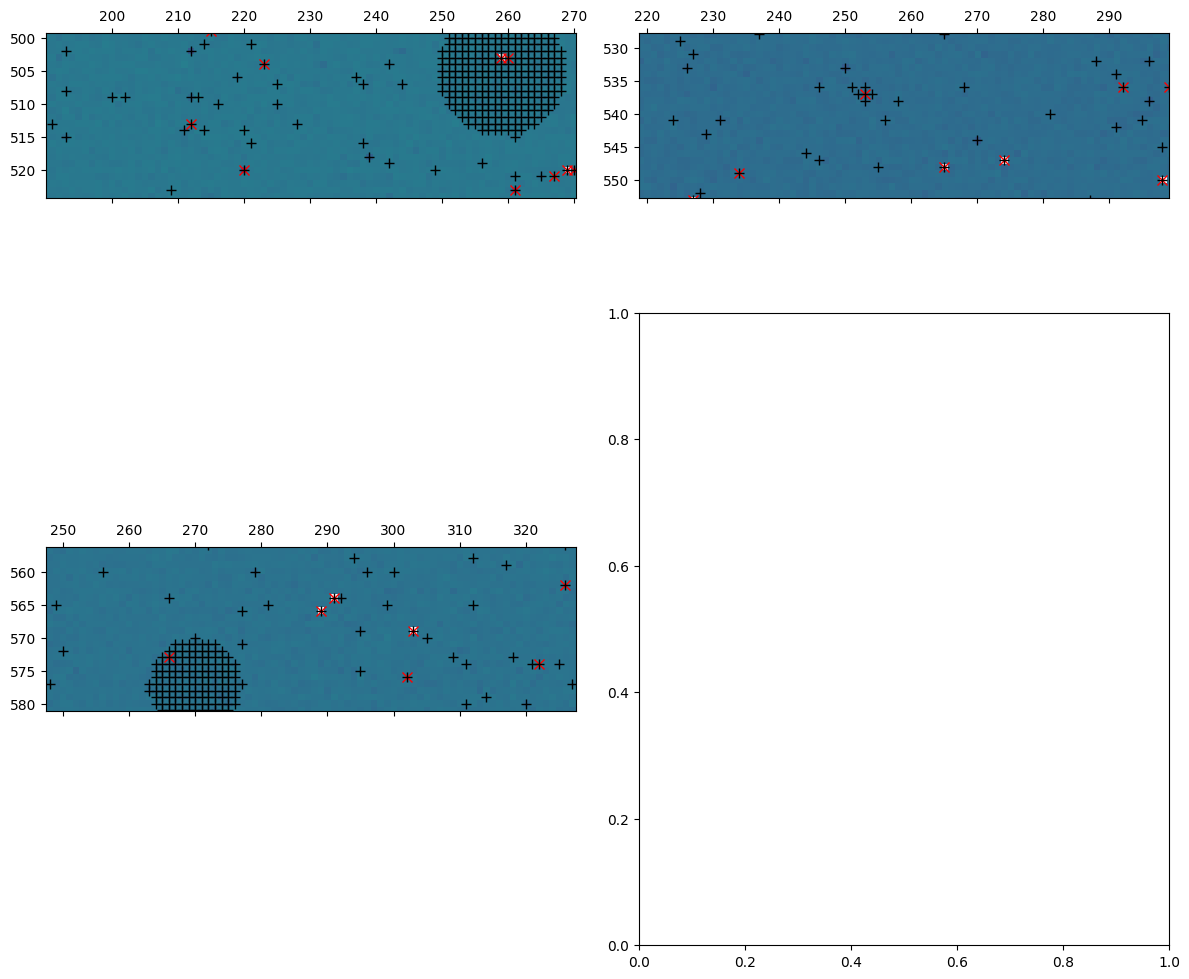

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, flt_file in enumerate(flt_files):
    row = int(i/2)
    col = i%2
    
    with fits.open(flt_file) as hdu:
        flt_wcs = wcs.WCS(hdu[1].header)
        data = hdu[1].data
        dq = hdu[3].data
    
    ax[row, col].matshow(np.log10(data), origin='upper')
    ax[row, col].plot(*np.argwhere(dq >= 4096).T[::-1], 'rx', ls='None', markersize=7)
    ax[row, col].plot(*np.argwhere(dq & (1 << int(np.log2(64)))).T[::-1], 'yo', ls='None', markersize=7)
    ax[row, col].plot(*np.argwhere(dq != 0).T[::-1], 'k+', ls='None', markersize=7)
    
    #ax[row, col].set_xlim(500, 650)
    #ax[row, col].set_ylim(500, 650)
    ax[row, col].set_xlim(radec_lims.to_pixel(flt_wcs)[0])
    ax[row, col].set_ylim(radec_lims.to_pixel(flt_wcs)[1])
    ax[row, col].set(adjustable='box', aspect='equal')
    
    
fig.tight_layout()

Red crosses are flagged pixels as comsic rays. Black plus symbols are all bad pixels. Yellow dots are warm pixels that we added back as good pixels.

## Clean up

In [13]:
# Remove all the files in the notebook directory with the following suffixes.
files_to_clean = ['coo', 'png', 'fits', 'match', 'log', 'list']

for suffix in files_to_clean:
    filelist=glob.glob("./*.{}".format(suffix))

    for file in filelist:
        os.remove(file)
        
# Remove temporary directory.
if os.path.isdir(temp_dir):
    shutil.rmtree(temp_dir)